<a href="https://colab.research.google.com/github/atjessehill/Thesis-Notebooks/blob/main/Music_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import glob
from os import path
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from google.colab import drive
import json
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
from sklearn import preprocessing
import statistics
from keras import backend as K
import scipy
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
keras.backend.clear_session()

In [ ]:
BASE = 'drive/My Drive'
SONG_SAMPLE_PATH = 'Thesis/Samples'
DATA_SAVE_PATH = 'Thesis/InputData'

In [ ]:
""" 

Mostly unneeded code at this point, this was from earlier experiments using 
matrix of MFCC's, which needed to be rescaled.

"""

def load_npy(path, fold):
  x_train = np.load(os.path.join(path,'x_train_'+str(fold)+'.npy'))
  x_test = np.load(os.path.join(path,'x_test_'+str(fold)+'.npy'))
  y_train = np.load(os.path.join(path,'y_train_'+str(fold)+'.npy'))
  y_test = np.load(os.path.join(path,'y_test_'+str(fold)+'.npy'))
  x_train = x_train[..., np.newaxis]
  x_test = x_test[..., np.newaxis]
  return x_train, x_test, y_train, y_test
  # imgs_validate = np.load('imgs_validate.npy')

def rescale_data():
  scaler = preprocessing.MinMaxScaler()
  mfcc = []
  i = 0
  for i, (d) in enumerate(data['mfcc']):
    scaler.fit(d)
    transform = scaler.transform(d)
    mfcc.append(transform)
  x = np.array(mfcc)
  y = np.array(data['labels'])

  return x, y

def load_auto(path):
  with open(os.path.join(BASE, DATA_SAVE_PATH, path), 'r') as fp:
    data = json.load(fp)
  x = np.empty(shape=(len(data['mfcc']), 18))
  y = np.empty(shape=(len(data['labels']), 1))
  for i in data['mfcc']:
    np.append(x, np.array(i))

  for i in data['lables']:
    np.append(y, )

  x = np.array()
  y = np.array()


# path to images dataset. Recommended to write down entire path to avoid errors (i.e "C:/User/Desktop.../raw/)
def load_data(path):
  with open(os.path.join(BASE, DATA_SAVE_PATH, path), 'r') as fp:
    data = json.load(fp)

  x = np.array(data['mfcc'])
  y = np.array(data['labels'])
  return x, y

def load_splits():
  with open(os.path.join(BASE, DATA_SAVE_PATH, '10-fold-splits.json'), 'r') as fp:
    data = json.load(fp)

  return data


def prepare_datasets(path, test_size, validation_size=None, cnn=False):

  data = {}
  X, y = load_npy(path)
  # create train/test split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

  if validation_size:
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

  if cnn:
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    if validation_size:
      X_validation = X_validation[..., np.newaxis]

  data['X_train'] = X_train
  data['X_test'] = X_test
  data['y_train'] = y_train
  data['y_test'] = y_test

  if validation_size:
    data['X_validation'] = X_validation
    data['y_validation'] = y_validation

  return data

In [ ]:
def build_cnn_v2(input_shape):

  model = keras.Sequential()

  #1st conv layer
  # TODO adjust using horizontal filter for temporal features
  model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
  model.add(keras.layers.MaxPool2D((3, 3), strides=(2, 2), padding='same'))
  model.add(keras.layers.BatchNormalization())

  # #2nd conv layer
  # TODO adjust using vertical filter for timbral features
  model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
  model.add(keras.layers.MaxPool2D((4, 1), strides=(4, 1), padding='same'))
  model.add(keras.layers.BatchNormalization())

  # #3rd conv layer
  # TODO add 4th convolutional layer 
  model.add(keras.layers.Conv2D(32, (2, 2), activation='relu', input_shape=input_shape))
  model.add(keras.layers.MaxPool2D((2, 2), strides=(2, 2), padding='same'))
  model.add(keras.layers.BatchNormalization())

  # # flatten the output and feed it into the dense layer
  model.add(keras.layers.Flatten()) # converts 2D data into 1D
  # TODO 1024 add one more dense layer. Smoothly reduce # of neurons
  # Include new features here
  model.add(keras.layers.Dense(1024, activation='relu'))
  # model.add(keras.layers.Dense(512, activation='relu'))
  model.add(keras.layers.Dense(64, activation='relu'))
  model.add(keras.layers.Dropout(0.3))

  # # output layer
  model.add(keras.layers.Dense(2, activation='softmax'))

  return model

def build_cnn(input_shape):

  model = keras.Sequential()

  #1st conv layer
  model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
  model.add(keras.layers.MaxPool2D((3, 3), strides=(2, 2), padding='same'))
  model.add(keras.layers.BatchNormalization())

  # #2nd conv layer
  model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
  model.add(keras.layers.MaxPool2D((3, 3), strides=(2, 2), padding='same'))
  model.add(keras.layers.BatchNormalization())

  # #3rd conv layer
  model.add(keras.layers.Conv2D(32, (2, 2), activation='relu', input_shape=input_shape))
  model.add(keras.layers.MaxPool2D((2, 2), strides=(2, 2), padding='same'))
  model.add(keras.layers.BatchNormalization())

  # # flatten the output and feed it into the dense layer
  model.add(keras.layers.Flatten()) # converts 2D data into 1D
  # TODO 1024 add one more dense layer. Smoothly reduce # of neurons
  # Include new features here

  model.add(keras.layers.Dense(64, activation='relu'))
  model.add(keras.layers.Dropout(0.3))

  # # output layer
  model.add(keras.layers.Dense(2, activation='softmax'))

  return model

def build_lstm(input_shape):

  model = keras.Sequential()

  model.add(keras.layers.LSTM(256, input_shape=input_shape, return_sequences=True))
  model.add(keras.layers.LSTM(256))

  model.add(keras.layers.Dense(256, activation='relu'))
  model.add(keras.layers.Dense(256, activation='relu'))
  model.add(keras.layers.Dense(256, activation='relu'))
  model.add(keras.layers.Dense(256, activation='relu'))

  model.add(keras.layers.Dropout(0.30))

  model.add(keras.layers.Dense(2, activation='softmax'))

  return model

def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2, figsize=(5, 5))

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="upper left")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper left")
    axs[1].set_title("Error eval")
    # plt.figure(figsize=(30,30))
    plt.show()

In [ ]:
def run_cnn(X_train, X_test, y_train, y_test):
  input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
  model = build_cnn_v2(input_shape)
  optimizer = keras.optimizers.Adam(learning_rate=0.0001)
  model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])
  weights = os.path.join(BASE, 'Thesis', 'weights.h5')
  callbacks = [keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=30, min_delta=0, mode='max'), keras.callbacks.ModelCheckpoint(weights, monitor='val_accuracy', mode='max', save_best_only=True)]

  history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=8, epochs=200, callbacks=callbacks)

  plot_history(history)
  model.load_weights(weights)
  return model

def run_lstm(X_train, X_test, y_train, y_test):
    input_shape = (X_train.shape[1], X_train.shape[2])
    model = build_model(input_shape)
    optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=64, epochs=30)
    plot_history(history)

In [ ]:
splits = load_splits()

In [ ]:
dir = os.path.join(BASE, DATA_SAVE_PATH, 'Spectrograms_30sec', "*.npy")
clipSections = len(glob.glob(dir))
clipSections

2541

Starting 0
(2276, 128, 1292, 1)
(256, 128, 1292, 1)
(2276,)
(256,)
Epoch 1/200
285/285 [==============================] - 10s 37ms/step - loss: 0.7806 - accuracy: 0.6753 - val_loss: 4.3955 - val_accuracy: 0.3906
Epoch 2/200
285/285 [==============================] - 9s 31ms/step - loss: 0.3331 - accuracy: 0.8717 - val_loss: 1.7447 - val_accuracy: 0.5234
Epoch 3/200
285/285 [==============================] - 9s 30ms/step - loss: 0.1324 - accuracy: 0.9508 - val_loss: 1.2224 - val_accuracy: 0.5820
Epoch 4/200
285/285 [==============================] - 10s 37ms/step - loss: 0.0558 - accuracy: 0.9833 - val_loss: 1.7403 - val_accuracy: 0.5977
Epoch 5/200
285/285 [==============================] - 5s 18ms/step - loss: 0.0667 - accuracy: 0.9846 - val_loss: 2.9759 - val_accuracy: 0.5664
Epoch 6/200
285/285 [==============================] - 5s 18ms/step - loss: 0.0408 - accuracy: 0.9886 - val_loss: 1.9404 - val_accuracy: 0.5898
Epoch 7/200
285/285 [==============================] - 9s 31ms/step

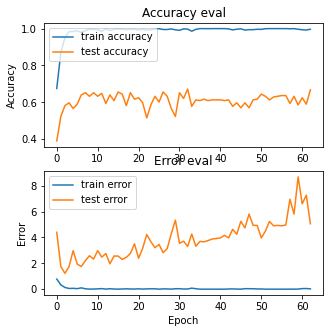

Correct Predictions: 13, incorrect predictions: 7
Starting 1
(2291, 128, 1292, 1)
(241, 128, 1292, 1)
(2291,)
(241,)
Epoch 1/200
287/287 [==============================] - 10s 34ms/step - loss: 0.7959 - accuracy: 0.6425 - val_loss: 1.4254 - val_accuracy: 0.7303
Epoch 2/200
287/287 [==============================] - 5s 18ms/step - loss: 0.3331 - accuracy: 0.8538 - val_loss: 0.7494 - val_accuracy: 0.6556
Epoch 3/200
287/287 [==============================] - 5s 18ms/step - loss: 0.1397 - accuracy: 0.9481 - val_loss: 1.1001 - val_accuracy: 0.5892
Epoch 4/200
287/287 [==============================] - 5s 18ms/step - loss: 0.1218 - accuracy: 0.9572 - val_loss: 1.2714 - val_accuracy: 0.5851
Epoch 5/200
287/287 [==============================] - 5s 18ms/step - loss: 0.0403 - accuracy: 0.9873 - val_loss: 1.7777 - val_accuracy: 0.5394
Epoch 6/200
287/287 [==============================] - 5s 18ms/step - loss: 0.0326 - accuracy: 0.9891 - val_loss: 2.2028 - val_accuracy: 0.5353
Epoch 7/200
287/28

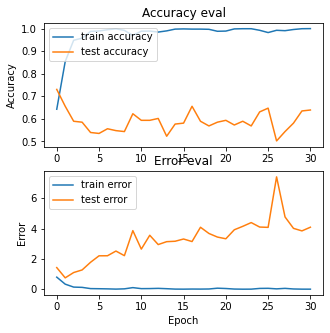

Correct Predictions: 14, incorrect predictions: 5
Starting 2
(2285, 128, 1292, 1)
(247, 128, 1292, 1)
(2285,)
(247,)
Epoch 1/200
286/286 [==============================] - 10s 35ms/step - loss: 0.8579 - accuracy: 0.6473 - val_loss: 6.0139 - val_accuracy: 0.4494
Epoch 2/200
286/286 [==============================] - 9s 31ms/step - loss: 0.3370 - accuracy: 0.8604 - val_loss: 0.8003 - val_accuracy: 0.6559
Epoch 3/200
286/286 [==============================] - 8s 30ms/step - loss: 0.1743 - accuracy: 0.9414 - val_loss: 0.8227 - val_accuracy: 0.6883
Epoch 4/200
286/286 [==============================] - 11s 39ms/step - loss: 0.0790 - accuracy: 0.9755 - val_loss: 0.7323 - val_accuracy: 0.7490
Epoch 5/200
286/286 [==============================] - 5s 18ms/step - loss: 0.0599 - accuracy: 0.9838 - val_loss: 0.9476 - val_accuracy: 0.7368
Epoch 6/200
286/286 [==============================] - 5s 18ms/step - loss: 0.0441 - accuracy: 0.9869 - val_loss: 1.4025 - val_accuracy: 0.6923
Epoch 7/200
286/2

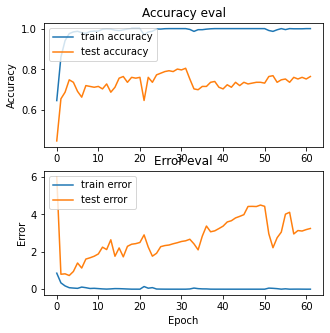

Correct Predictions: 16, incorrect predictions: 3
Starting 3
(2272, 128, 1292, 1)
(260, 128, 1292, 1)
(2272,)
(260,)
Epoch 1/200
284/284 [==============================] - 10s 36ms/step - loss: 0.7896 - accuracy: 0.6496 - val_loss: 1.2521 - val_accuracy: 0.5423
Epoch 2/200
284/284 [==============================] - 9s 30ms/step - loss: 0.3935 - accuracy: 0.8363 - val_loss: 0.9149 - val_accuracy: 0.5731
Epoch 3/200
284/284 [==============================] - 9s 31ms/step - loss: 0.2204 - accuracy: 0.9331 - val_loss: 1.1315 - val_accuracy: 0.6269
Epoch 4/200
284/284 [==============================] - 5s 17ms/step - loss: 0.1088 - accuracy: 0.9604 - val_loss: 1.6714 - val_accuracy: 0.6269
Epoch 5/200
284/284 [==============================] - 5s 17ms/step - loss: 0.0646 - accuracy: 0.9789 - val_loss: 2.0447 - val_accuracy: 0.5885
Epoch 6/200
284/284 [==============================] - 9s 32ms/step - loss: 0.0386 - accuracy: 0.9877 - val_loss: 1.9256 - val_accuracy: 0.6423
Epoch 7/200
284/28

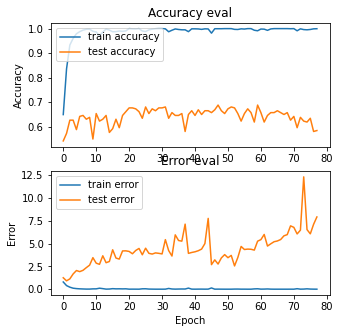

Correct Predictions: 14, incorrect predictions: 5
Starting 4
(2270, 128, 1292, 1)
(262, 128, 1292, 1)
(2270,)
(262,)
Epoch 1/200
284/284 [==============================] - 10s 36ms/step - loss: 0.8798 - accuracy: 0.6515 - val_loss: 2.8050 - val_accuracy: 0.5496
Epoch 2/200
284/284 [==============================] - 10s 34ms/step - loss: 0.3537 - accuracy: 0.8449 - val_loss: 0.7232 - val_accuracy: 0.5954
Epoch 3/200
284/284 [==============================] - 5s 18ms/step - loss: 0.1759 - accuracy: 0.9278 - val_loss: 1.1331 - val_accuracy: 0.5382
Epoch 4/200
284/284 [==============================] - 5s 18ms/step - loss: 0.1212 - accuracy: 0.9599 - val_loss: 1.6381 - val_accuracy: 0.5573
Epoch 5/200
284/284 [==============================] - 5s 18ms/step - loss: 0.1550 - accuracy: 0.9533 - val_loss: 1.7276 - val_accuracy: 0.5305
Epoch 6/200
284/284 [==============================] - 9s 32ms/step - loss: 0.0890 - accuracy: 0.9656 - val_loss: 1.2184 - val_accuracy: 0.6679
Epoch 7/200
284/2

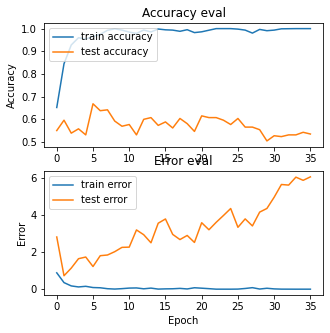

Correct Predictions: 12, incorrect predictions: 7
Starting 5
(2285, 128, 1292, 1)
(247, 128, 1292, 1)
(2285,)
(247,)
Epoch 1/200
286/286 [==============================] - 9s 32ms/step - loss: 0.8921 - accuracy: 0.6713 - val_loss: 1.0703 - val_accuracy: 0.4008
Epoch 2/200
286/286 [==============================] - 9s 31ms/step - loss: 0.3210 - accuracy: 0.8761 - val_loss: 0.9262 - val_accuracy: 0.5506
Epoch 3/200
286/286 [==============================] - 9s 30ms/step - loss: 0.1283 - accuracy: 0.9558 - val_loss: 1.2618 - val_accuracy: 0.6235
Epoch 4/200
286/286 [==============================] - 5s 18ms/step - loss: 0.0473 - accuracy: 0.9895 - val_loss: 1.7177 - val_accuracy: 0.5870
Epoch 5/200
286/286 [==============================] - 5s 18ms/step - loss: 0.0319 - accuracy: 0.9921 - val_loss: 2.0147 - val_accuracy: 0.6032
Epoch 6/200
286/286 [==============================] - 5s 18ms/step - loss: 0.0358 - accuracy: 0.9908 - val_loss: 2.5059 - val_accuracy: 0.5911
Epoch 7/200
286/286

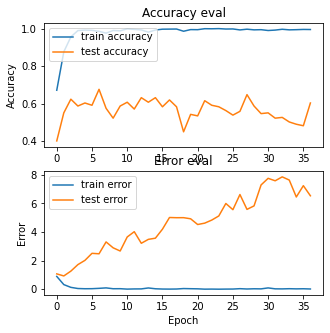

Correct Predictions: 13, incorrect predictions: 6
Starting 6
(2290, 128, 1292, 1)
(242, 128, 1292, 1)
(2290,)
(242,)
Epoch 1/200
287/287 [==============================] - 10s 36ms/step - loss: 0.8138 - accuracy: 0.6629 - val_loss: 4.2251 - val_accuracy: 0.3719
Epoch 2/200
287/287 [==============================] - 9s 31ms/step - loss: 0.3367 - accuracy: 0.8681 - val_loss: 0.6917 - val_accuracy: 0.6736
Epoch 3/200
287/287 [==============================] - 5s 18ms/step - loss: 0.1738 - accuracy: 0.9349 - val_loss: 1.0199 - val_accuracy: 0.6446
Epoch 4/200
287/287 [==============================] - 9s 33ms/step - loss: 0.1015 - accuracy: 0.9603 - val_loss: 1.1590 - val_accuracy: 0.7231
Epoch 5/200
287/287 [==============================] - 5s 18ms/step - loss: 0.0381 - accuracy: 0.9878 - val_loss: 1.4317 - val_accuracy: 0.7231
Epoch 6/200
287/287 [==============================] - 5s 18ms/step - loss: 0.0381 - accuracy: 0.9865 - val_loss: 2.0329 - val_accuracy: 0.6322
Epoch 7/200
287/28

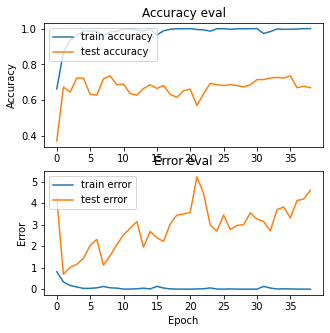

Correct Predictions: 15, incorrect predictions: 4
Starting 7
(2274, 128, 1292, 1)
(258, 128, 1292, 1)
(2274,)
(258,)
Epoch 1/200
285/285 [==============================] - 10s 35ms/step - loss: 0.7296 - accuracy: 0.6834 - val_loss: 0.8098 - val_accuracy: 0.4767
Epoch 2/200
285/285 [==============================] - 9s 31ms/step - loss: 0.2865 - accuracy: 0.8852 - val_loss: 1.3945 - val_accuracy: 0.5388
Epoch 3/200
285/285 [==============================] - 9s 32ms/step - loss: 0.1346 - accuracy: 0.9529 - val_loss: 1.2331 - val_accuracy: 0.6279
Epoch 4/200
285/285 [==============================] - 5s 18ms/step - loss: 0.0580 - accuracy: 0.9815 - val_loss: 1.8530 - val_accuracy: 0.5891
Epoch 5/200
285/285 [==============================] - 5s 18ms/step - loss: 0.0263 - accuracy: 0.9925 - val_loss: 2.5014 - val_accuracy: 0.5930
Epoch 6/200
285/285 [==============================] - 5s 18ms/step - loss: 0.0619 - accuracy: 0.9793 - val_loss: 2.5790 - val_accuracy: 0.5426
Epoch 7/200
285/28

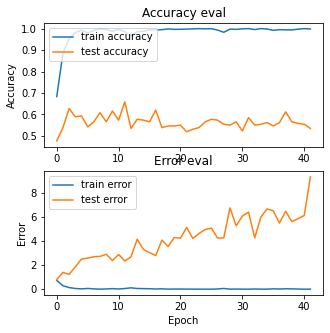

Correct Predictions: 13, incorrect predictions: 6
Starting 8
(2260, 128, 1292, 1)
(272, 128, 1292, 1)
(2260,)
(272,)
Epoch 1/200
283/283 [==============================] - 10s 37ms/step - loss: 0.7975 - accuracy: 0.6664 - val_loss: 2.7425 - val_accuracy: 0.5331
Epoch 2/200
283/283 [==============================] - 9s 32ms/step - loss: 0.3520 - accuracy: 0.8447 - val_loss: 1.1179 - val_accuracy: 0.5956
Epoch 3/200
283/283 [==============================] - 5s 18ms/step - loss: 0.1716 - accuracy: 0.9451 - val_loss: 2.0238 - val_accuracy: 0.5809
Epoch 4/200
283/283 [==============================] - 5s 18ms/step - loss: 0.1218 - accuracy: 0.9677 - val_loss: 2.3768 - val_accuracy: 0.5588
Epoch 5/200
283/283 [==============================] - 5s 19ms/step - loss: 0.0526 - accuracy: 0.9876 - val_loss: 3.0211 - val_accuracy: 0.5588
Epoch 6/200
283/283 [==============================] - 5s 18ms/step - loss: 0.0172 - accuracy: 0.9956 - val_loss: 3.3521 - val_accuracy: 0.5846
Epoch 7/200
283/28

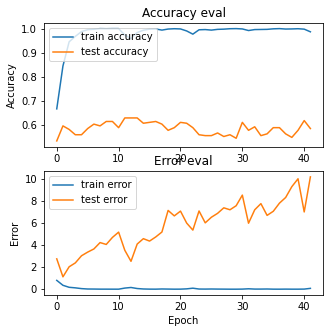

Correct Predictions: 14, incorrect predictions: 5
Starting 9
(2285, 128, 1292, 1)
(247, 128, 1292, 1)
(2285,)
(247,)
Epoch 1/200
286/286 [==============================] - 10s 33ms/step - loss: 0.8920 - accuracy: 0.6932 - val_loss: 0.6836 - val_accuracy: 0.6113
Epoch 2/200
286/286 [==============================] - 9s 31ms/step - loss: 0.2755 - accuracy: 0.8788 - val_loss: 0.8934 - val_accuracy: 0.6964
Epoch 3/200
286/286 [==============================] - 8s 29ms/step - loss: 0.1464 - accuracy: 0.9527 - val_loss: 1.0770 - val_accuracy: 0.7004
Epoch 4/200
286/286 [==============================] - 10s 36ms/step - loss: 0.0788 - accuracy: 0.9786 - val_loss: 1.5330 - val_accuracy: 0.7287
Epoch 5/200
286/286 [==============================] - 5s 18ms/step - loss: 0.0385 - accuracy: 0.9882 - val_loss: 1.6444 - val_accuracy: 0.6518
Epoch 6/200
286/286 [==============================] - 5s 18ms/step - loss: 0.0458 - accuracy: 0.9869 - val_loss: 1.6734 - val_accuracy: 0.6721
Epoch 7/200
286/2

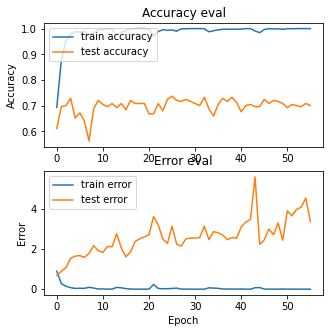

Correct Predictions: 13, incorrect predictions: 6


In [ ]:
maxes = []
for fold in range(0, 10):

  testSamples = splits[fold]['test']
  trainLength = 0
  testLength = 0
  ytrain = []
  ytest = []
  songSections = []
  songClassification = []


  # Calculates the size of train and test folds
  for i, (file) in enumerate(splits[fold]['train']):
    dir = os.path.join(BASE, DATA_SAVE_PATH, 'Spectrograms_30sec', file.replace(".mp3", "*"))
    clipSections = len(glob.glob(dir))
    trainLength+= clipSections
    if os.path.exists(os.path.join(BASE, 'Thesis', 'Samples', 'FULL_TRACKS', 'noDJ', file)):
      ytrain_ = [0]*clipSections
    elif os.path.exists(os.path.join(BASE, 'Thesis', 'Samples', 'FULL_TRACKS', 'yesDJ', file)):
      ytrain_ = [1]*clipSections
    else:
      print("Could not find file", file)
    ytrain = ytrain+ytrain_
  
  for i, (file) in enumerate(splits[fold]['test']):
    dir = os.path.join(BASE, DATA_SAVE_PATH, 'Spectrograms_30sec', file.replace(".mp3", "*"))
    clipSections = len(glob.glob(dir))
    testLength+= clipSections
    songSections.append(clipSections)
    if os.path.exists(os.path.join(BASE, 'Thesis', 'Samples', 'FULL_TRACKS', 'noDJ', file)):
      ytest_ = [0]*clipSections
      songClassification.append(0)
    elif os.path.exists(os.path.join(BASE, 'Thesis', 'Samples', 'FULL_TRACKS', 'yesDJ', file)):
      ytest_ = [1]*clipSections
      songClassification.append(1)
    else:
      print("Could not find file", file)

    ytest = ytest+ytest_
  
  # Create test/train data arrays

  x_train = np.ndarray((trainLength, 128, 1292), dtype=np.uint8)
  x_test = np.ndarray((testLength, 128, 1292), dtype=np.uint8)
  y_train = np.array(ytrain)
  y_test = np.array(ytest)

  # Load test/train data
  loc = 0
  for url in splits[fold]['train']:
    url = url.replace('.mp3', '')
    for loadpath in glob.glob(os.path.join(BASE, DATA_SAVE_PATH, 'Spectrograms_30sec', url+'*.npy')):
      x_train[loc] = np.load(loadpath)
      loc+=1
  x_train = x_train.astype('float32')
  x_train = x_train.astype('float32')
  mean = np.mean(x_train)
  std = np.mean(x_train)
  x_train -= mean
  x_train /= std
  x_train = x_train[..., np.newaxis]

  loc = 0
  for url in splits[fold]['test']:
    url = url.replace('.mp3', '')
    for loadpath in glob.glob(os.path.join(BASE, DATA_SAVE_PATH, 'Spectrograms_30sec', url+'*.npy')):
      x_test[loc] = np.load(loadpath)
      loc+=1
  x_test = x_test.astype('float32')
  x_test = x_test.astype('float32')
  mean = np.mean(x_test)
  std = np.mean(x_test)
  x_test -= mean
  x_test /= std
  x_test = x_test[..., np.newaxis]

  print(f"Starting {fold}")
  model = run_cnn(x_train, x_test, y_train, y_test)

  # Ensemble voting
  start = 0
  predictions = np.argmax(model.predict(x_test), axis=1)
  ensemblePrediction = []
  for song in range(0, len(songClassification)):
    correct = 0
    incorrect = 0

    for i, j in zip(y_test[start:start+songSections[song]], predictions[start:start+songSections[song]]):
      if i==j==songClassification[song]:
        correct+=1
    # print(f"{correct} {songSections[song]}")
    start=start+songSections[song]
    ensemblePrediction.append(correct/songSections[song])


  correctPreds = 0
  incorrectPreds = 0
  for i in ensemblePrediction:
    if i >= .50:
      correctPreds+=1
    else:
      incorrectPreds+=1

  print(f"Correct Predictions: {correctPreds}, incorrect predictions: {incorrectPreds}")

  # maxes.append(m)
# avg = sum(maxes)/len(maxes)
# std = statistics.stdev(maxes)
# print(f"AVG: {avg} STD: {std} ")


In [ ]:
ensemblePrediction

[0.8571428571428571,
 0.6428571428571429,
 0.0,
 0.8125,
 0.5833333333333334,
 0.8181818181818182,
 0.6666666666666666,
 0.3333333333333333,
 0.75,
 0.8,
 0.35714285714285715,
 0.7857142857142857,
 0.8888888888888888,
 0.8666666666666667,
 0.8333333333333334,
 1.0,
 0.3333333333333333,
 0.4375,
 1.0,
 0.14285714285714285]